<a href="https://colab.research.google.com/github/rebeccadimatteo/FitDiary_FIA/blob/main/RegressioneNoFeatureScalingAndSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressione SENZA Feature Scaling e Feature selection

## Ottenimento del Dataset

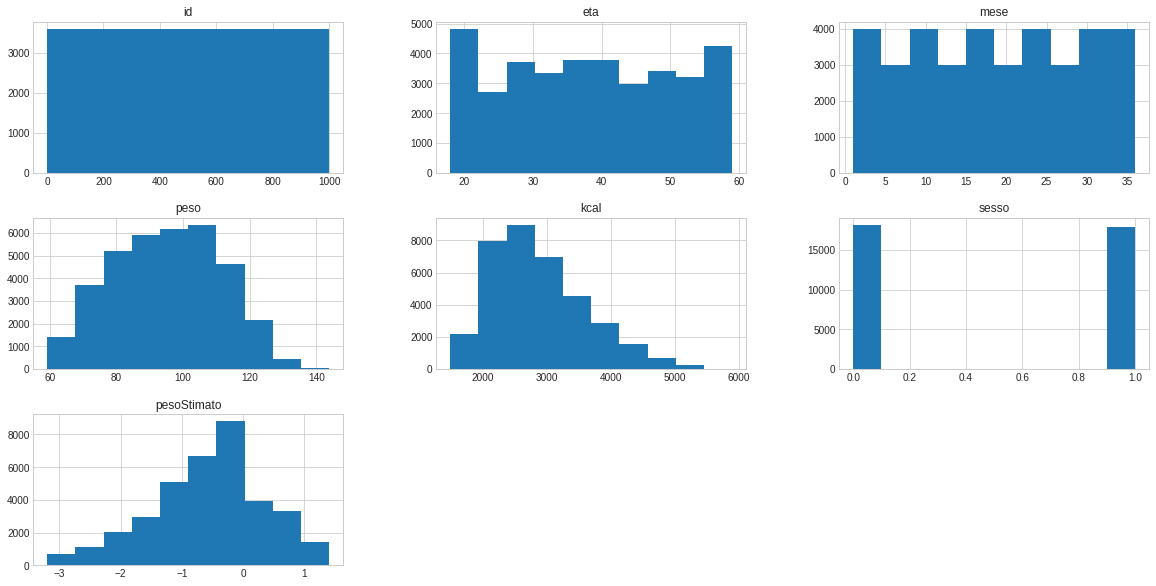

,id,eta,mese,peso,kcal,sesso,pesoStimato
0,1,24,1,107.00000,2688,0,-1.848958
1,1,24,2,108.84896,2538,0,-0.940110
2,1,24,3,109.78907,2929,0,-0.564015
3,1,24,4,110.35309,2526,0,-0.984957
4,1,24,5,111.33804,2658,0,-2.140707


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from six.moves import urllib

import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (20,10)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/FitDiary_FIA/master/dataset.csv"

#fetch dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "datasetRegressioneNoFeatureScaling.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/datasetRegressioneNoFeatureScaling.csv")
df=df[["id", "eta", "mese", "peso", "kcal", "sesso", "pesoStimato"]]
df.hist()
plt.show()
df.head(5)

## 1) Data Cleaning

### 1.1) Descrizione del Dataset 

In [ ]:
#descrizione dataset
df.describe()

,id,eta,mese,peso,kcal,sesso,pesoStimato
count,36000.000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,500.500,38.308000,18.500000,95.203136,2879.582611,0.497000,-0.571741
std,288.679,12.166234,10.388439,16.069207,738.609226,0.499998,0.929684
min,1.000,18.000000,1.000000,59.222496,1488.000000,0.000000,-3.196685
25%,250.750,28.000000,9.750000,82.672719,2313.000000,0.000000,-1.128062
50%,500.500,38.000000,18.500000,95.666960,2753.000000,0.000000,-0.468522
75%,750.250,49.000000,27.250000,107.738935,3322.000000,1.000000,0.000000
max,1000.000,59.000000,36.000000,143.836010,5895.000000,1.000000,1.402878


### 1.2) Verifica dei valori null

In [ ]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [ ]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.4) Dataplot

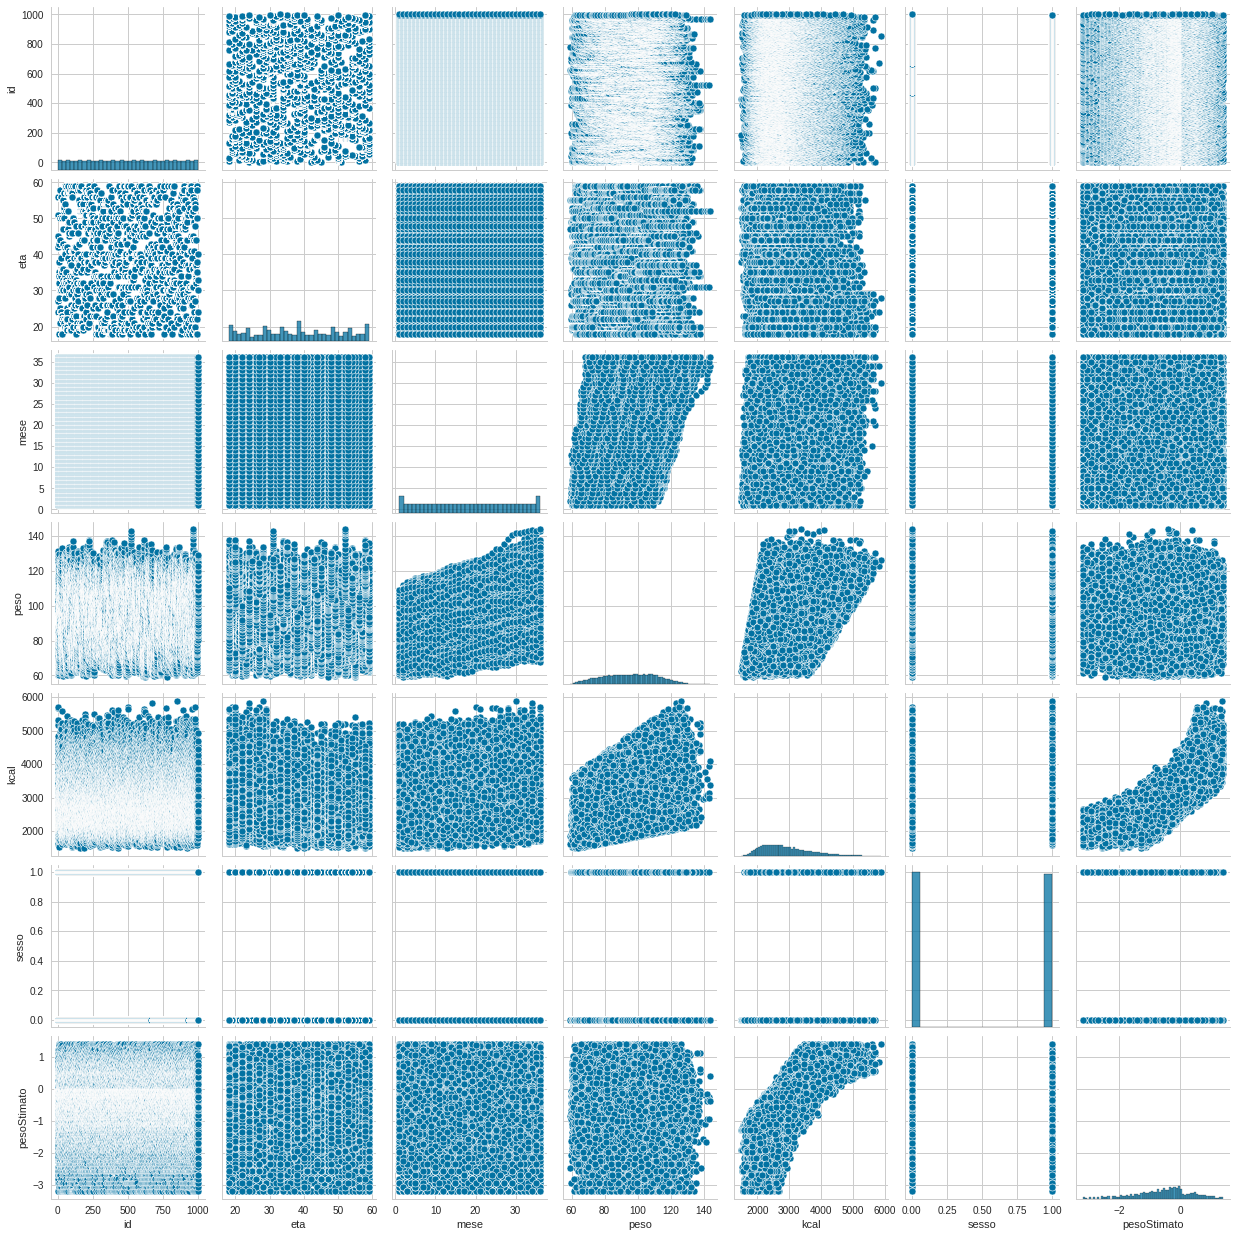

In [ ]:
#creazione pairplot del dataset
sb.pairplot(df)

#salvataggio plot
plt.savefig('pairplor.png')

### 1.5) Plot Linearità e Multicollinearità

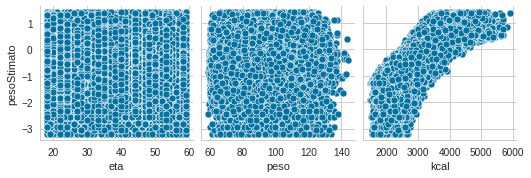

In [ ]:
#creazione linearPlot
sb.pairplot(df,x_vars=["eta", "peso", "kcal"], y_vars=["pesoStimato"])

#salvataggio linearPlot
plt.savefig('linearPlot.png')

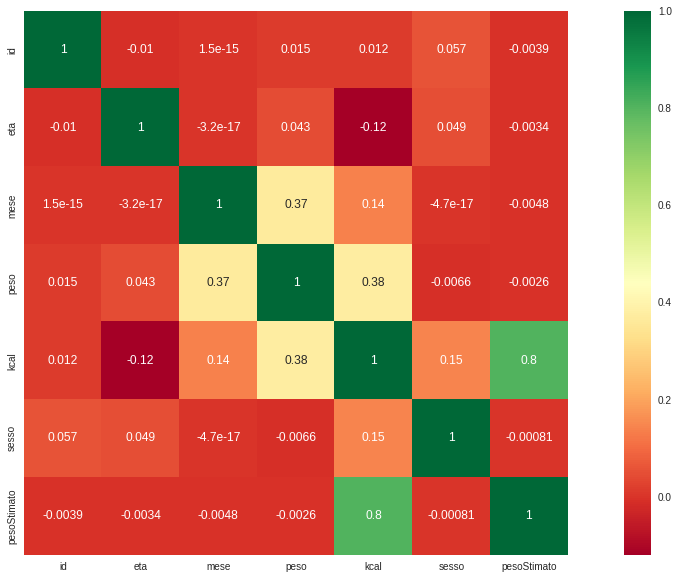

In [ ]:
#creazione heatMap
sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) Definizione Classe Metrics

In [ ]:
import numpy as np
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse  
  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

### 2.2) Definizione Classe Metrics Result Container

In [ ]:
#classe che contiene i risultati delle metriche
class MetricsResultContainer:
  meanMAE = []
  meanMSE = []
  meanRMSE = []
  #costruttore
  def __init__(self,model,alg,param,metricsMean):
    self.model=model
    self.alg=alg
    self.param=param
    self.metricsMean=metricsMean
    self.meanMAE = []
    self.meanMSE = []
    self.meanRMSE = []
  
  #stampa delle metriche
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanMAE.append(m.mae)
      self.meanMSE.append(m.mse)
      self.meanRMSE.append(m.rmse)
    print("meanMAE=",np.mean(self.meanMAE))    
    print("meanMSE=",np.mean(self.meanMSE))    
    print("meanRMSE=",np.mean(self.meanRMSE))

### 2.3) Definizione funzione generate model 

In [ ]:
from sklearn import model_selection
from yellowbrick.base import Visualizer
from re import M
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from termcolor import colored as cl
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import copy

#genera un modello con con uno specifico algoritmo per lo splitter
def generateModel(alg, model):
  #array di metriche (MAE,MSE,RMSE)
  metrics1 = []

  #generazione n_split test/trainig sets
  for train_index, test_index in alg.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #training dell'algoritmo sui training set
    model.fit(X_train,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = model.predict(X_test)
    #calcolo metriche predizione
    metrics1.append(
        Metrics1(
            metrics.mean_absolute_error(y_test,y_pred),
            metrics.mean_squared_error(y_test,y_pred),
            np.sqrt(metrics.mean_squared_error(y_test,y_pred))
        )
    )
  return metrics1

#Scelta variabile dipendente (y) e indipendenti (X)
X=df[["eta", "peso", "kcal", "sesso"]]
y=df.pesoStimato
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#Kf con k gruppi
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni della ram del coso
rkfRF = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
#risultati: array di array di metriche
metricsResults = []

## 3) Model Testing

### 3.1) Linear Regression

In [ ]:
 from sklearn.linear_model import LinearRegression
#regressione lineare
print("Linear Regression - KF")
#K-fold
m = MetricsResultContainer("Linear Regression","KF","Default",
  generateModel(kf,LinearRegression())
)
metricsResults.append(m)
m.printMetrics()
#Repeated K-fold
print("\nLinear Regression - RKF")
m = MetricsResultContainer("Linear Regression","RKF","Default",
  generateModel(rkf, LinearRegression())
)
metricsResults.append(m)
m.printMetrics()

Linear Regression - KF
meanMAE= 0.32364806150367553
meanMSE= 0.17880114537618333
meanRMSE= 0.422817279631319

Linear Regression - RKF
meanMAE= 0.3236404005191412
meanMSE= 0.17880199106831995
meanRMSE= 0.4228356751507702


### 3.2) DecisionTree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
print("DecisionTreeRegressor - KF")
#K-fold
m = MetricsResultContainer("DecisionTree Regression","KF","Default",
  generateModel(kf, DecisionTreeRegressor())
)
metricsResults.append(m)
m.printMetrics()


print("\nDecisionTreeRegressor - RKF")
#Repeated K-fold
m = MetricsResultContainer("DecisionTree Regression","RKF","Default",
  generateModel(rkf, DecisionTreeRegressor())
)
metricsResults.append(m)
m.printMetrics()


DecisionTreeRegressor - KF
meanMAE= 0.31555429555763886
meanMSE= 0.2330161466850962
meanRMSE= 0.48260460257650317

DecisionTreeRegressor - RKF
meanMAE= 0.31313444808075835
meanMSE= 0.22886455320207366
meanRMSE= 0.4783678713276462


### 3.3) Lasso Regression

In [ ]:
from sklearn import linear_model
lassoReg = linear_model.Lasso()
print("Lasso Regression - KF")
#K-fold
m = MetricsResultContainer("Lasso Regression","KF","Default",
  generateModel(kf, lassoReg)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RKF")
#Repeated K-fold
m = MetricsResultContainer("Lasso Regression","RKF","Default",
  generateModel(rkfRF, lassoReg)
)
metricsResults.append(m)
m.printMetrics()

Lasso Regression - KF
meanMAE= 0.3573036261110274
meanMSE= 0.21120416338505119
meanRMSE= 0.459548279072586

Lasso Regression - RKF
meanMAE= 0.3573153523597425
meanMSE= 0.21120820294364565
meanRMSE= 0.4595636500355065


### 3.4) Ridge Regression

In [ ]:
from sklearn import linear_model
bridgeReg = linear_model.Ridge()
#K-fold
print("Ridge Regression - KF")
m = MetricsResultContainer("Ridge Regression","KF","Default",
  generateModel(kf, bridgeReg)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RKF")
#Repeated K-fold
m = MetricsResultContainer("Ridge Regression","RKF","Default",
  generateModel(rkfRF, bridgeReg)
)
metricsResults.append(m)
m.printMetrics()

Ridge Regression - KF
meanMAE= 0.32364781268926646
meanMSE= 0.17880114337460082
meanRMSE= 0.4228172786109189

Ridge Regression - RKF
meanMAE= 0.32365566589073264
meanMSE= 0.17881687194272594
meanRMSE= 0.4228590166448399


### 3.5) Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

print("RandomForestRegressor - KF")
#K-fold
m = MetricsResultContainer("RandomForest Regression","KF","Default",
  generateModel(kf, RandomForestRegressor())
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor  - RKF")
#Repeated K-fold
m = MetricsResultContainer("RandomForest Regression","RKF","Default",
  generateModel(rkfRF,RandomForestRegressor())
)
metricsResults.append(m)
m.printMetrics()

RandomForestRegressor - KF
meanMAE= 0.25199889841358447
meanMSE= 0.1326286165494689
meanRMSE= 0.3641346766836637

RandomForestRegressor  - RKF
meanMAE= 0.2518132589706983
meanMSE= 0.13204939331079307
meanRMSE= 0.3633725836627251


### 3.6) SVR Regression

In [ ]:
from sklearn.svm import SVR
print("SVR - KF")
#K-fold
m = MetricsResultContainer("SVR Regression","KF","Default",
  generateModel(kf, SVR())
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RKF")
#Repeated K-fold
m = MetricsResultContainer("SVR Regression","RKF","Default",
  generateModel(rkfRF, SVR())
)
metricsResults.append(m)
m.printMetrics()

SVR - KF
meanMAE= 0.3079154580010541
meanMSE= 0.17193545703505547
meanRMSE= 0.41463535720288713

SVR - RKF
meanMAE= 0.3095019800356363
meanMSE= 0.1737407630214184
meanRMSE= 0.41681261283138443


## 4) Creazione pipeline di machine learning

In [ ]:
!pip install sklearn2pmml

     |████████████████████████████████| 6.0 MB 6.3 MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.77.2-py3-none-any.whl size=5996370 sha256=58455f48184955482d941f18f6f42ead1f02295672fb15a45c4e753bec2487da
  Stored in directory: /root/.cache/pip/wheels/59/79/c8/d0020c585f6a82ebb14d9b2b626f1b94390ecadec161886ad5
Successfully built sklearn2pmml


In [ ]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
#creazione pipeline del modello più performante
#RandomForestRegression
pipeline = PMMLPipeline([("Regression", RandomForestRegressor())])
pipeline.fit(X,y)
#estrazione pipiline in file .pmml
sklearn2pmml(pipeline, "RegressionPesoStimato.pmml", with_repr = True)